# 3.2 Classification: Job Title Prediction with RAPIDS cuML

This notebook predicts job titles using various feature sets and RAPIDS cuML models.

## RAPIDS Environment Assertion

In [1]:
import os
assert os.environ.get("RAPIDS_NO_INITIALIZE") is None, "Make sure you're using the RAPIDS Kaggle Docker image, GPU T4 as accelerator"
!nvidia-smi

Fri May 16 16:12:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Libraries Required

In [2]:
import joblib
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz, hstack

from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.inspection import permutation_importance

## Data Loading

### A) Loading the Structured data

In [3]:
train_df = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/train_data.parquet')
dev_df   = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/dev_data.parquet')
test_df  = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/test_data.parquet')

### B) Loading Embeddings
- Introducing controlled perturbation in dev and test sets, to simulate the real-world variability in job descriptions, responsibilities and skills phrasing.  
- This Step ensures model robustness against minor linguistic imperfections encountered in deployment scenarios.

In [4]:
# Loading SBERT fused embeddings
X_train_emb = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_train.npy')
X_dev_emb   = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_dev.npy')
X_test_emb  = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_test.npy')

# Applying perturbation to SBERT fused embeddings
X_dev_emb += np.random.normal(0, 0.12, X_dev_emb.shape)
X_test_emb += np.random.normal(0, 0.12, X_test_emb.shape)

# -----------------------------------------------------

# Loading TF-IDF embeddings
X_train_skills = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_train.npz')
X_dev_skills   = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_dev.npz')
X_test_skills  = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_test.npz')

# Applying noise to TF-IDF skills embeddings (only to non-zero entries to maintain sparsity)
X_dev_skills.data += np.random.normal(0, 0.24, X_dev_skills.data.shape)
X_test_skills.data += np.random.normal(0, 0.24, X_test_skills.data.shape)

# Clipping TF-IDF embeddings to ensure no negatives
X_dev_skills.data = np.clip(X_dev_skills.data, 0, None)
X_test_skills.data = np.clip(X_test_skills.data, 0, None)

In [5]:
y_train = train_df['Job Title_encoded'].values
y_dev   = dev_df['Job Title_encoded'].values
y_test  = test_df['Job Title_encoded'].values

drop_cols = ['Job Title_encoded', 'salary_avg']
X_train_struct = train_df.drop(columns=drop_cols).values
X_dev_struct   = dev_df.drop(columns=drop_cols).values
X_test_struct  = test_df.drop(columns=drop_cols).values

del dev_df, test_df
gc.collect();

## Class Imbalance Check

- We will visualize the class distribution for job titles.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


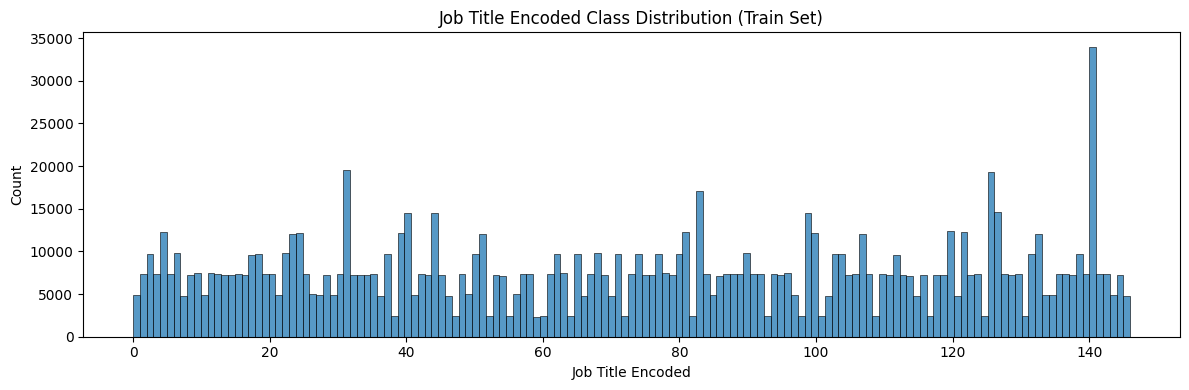

In [6]:
plt.figure(figsize=(12, 4))
sns.histplot(y_train, bins=147, kde=False)
plt.title('Job Title Encoded Class Distribution (Train Set)')
plt.xlabel('Job Title Encoded')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 1st Model: Logistic Regression - Trying Different Feature (X) Combinations

- We'll compare Logistic Regression model trained on: structured only, embeddings only, skills only, and a mix of them.

In [7]:
combos = {
    'structured': X_train_struct,
    'fused SBERT embeddings': X_train_emb,
    'tfidf embeddings': X_train_skills.toarray(),
    'str+emb': np.hstack([X_train_struct, X_train_skills.toarray()])
}
dev_combos = {
    'structured': X_dev_struct,
    'fused SBERT embeddings': X_dev_emb,
    'tfidf embeddings': X_dev_skills.toarray(),
    'str+emb': np.hstack([X_dev_struct, X_dev_skills.toarray()])
}

results = {}
for name, Xtr in combos.items():
    print(f'Training Logistic Regression on {name} features...')
    model = LogisticRegression(max_iter=100, penalty='l2')
    model.fit(Xtr, y_train)
    y_pred = model.predict(dev_combos[name])
    f1 = f1_score(y_dev, y_pred, average='macro')
    results[name] = f1
    print(f'Macro F1: {f1:.4f}')
    del Xtr, model
    gc.collect();

results

Training Logistic Regression on structured features...
Macro F1: 0.0071
Training Logistic Regression on fused SBERT embeddings features...
Macro F1: 0.9459
Training Logistic Regression on tfidf embeddings features...
Macro F1: 0.9744
Training Logistic Regression on str+emb features...
Macro F1: 0.9827


{'structured': 0.007089205428919761,
 'fused SBERT embeddings': 0.9458994970083426,
 'tfidf embeddings': 0.9743999117384404,
 'str+emb': 0.9826912718848261}

## Final Logistic Regression Model: Tuning and Evaluating on Test Set

- We'll use the best feature combo and tune the model.

In [8]:
best_combo = max(results, key=results.get)
print(f'Best feature set: {best_combo}')
Xtr = combos[best_combo]
Xdev = dev_combos[best_combo]
Xte = np.hstack([X_test_struct, X_test_skills.toarray()]) if best_combo == 'str+emb' else (
    X_test_struct if best_combo == 'structured' else (
        X_test_emb if best_combo == 'fused SBERT embeddings' else X_test_skills.toarray()
    )
)

# Hyperparameter tuning (C)
best_f1 = 0
best_C = 1.0
for C in [0.1, 1.0, 10.0]:
    model = LogisticRegression(max_iter=100, penalty='l2', C=C)
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xdev)
    f1 = f1_score(y_dev, y_pred, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_C = C
print(f'Best C: {best_C}, Dev Macro F1: {best_f1:.4f}')

Best feature set: str+emb
Best C: 10.0, Dev Macro F1: 0.9828


In [9]:
# Train on train, evaluate on test
model = LogisticRegression(max_iter=100, penalty='l2', C=best_C)
model.fit(Xtr, y_train)
y_test_pred = model.predict(Xte)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Macro F1: {test_f1:.4f}')

# Save model
joblib.dump(model, '/kaggle/working/logreg_cuml.joblib')

Test Macro F1: 0.9828


['/kaggle/working/logreg_cuml.joblib']

## Visual 1: Confusion Matrix for Logistic Regression (Top 10 Job Titles)

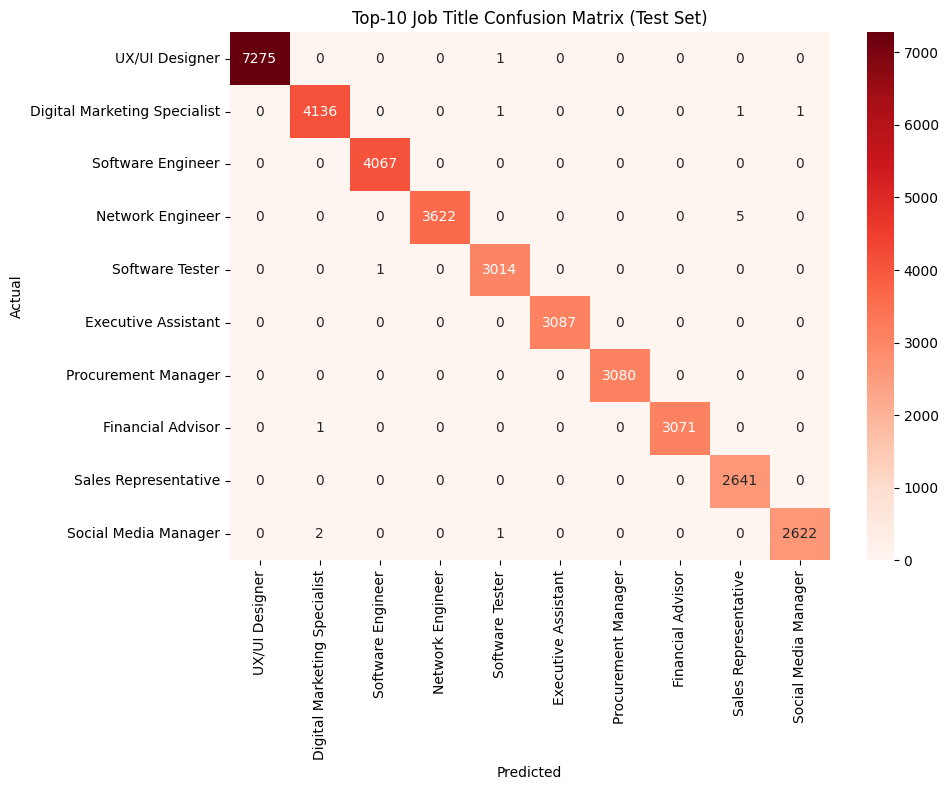

In [10]:
# Load label encoder to decode class names
le = joblib.load('/kaggle/input/ds-preprocessing-output-files/label_encoder_job_title (1).pkl')

# Get top 10 most common job titles
top_10_classes = pd.Series(y_train).value_counts().head(10).index
cm = confusion_matrix(y_test, y_test_pred, labels=top_10_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=le.inverse_transform(top_10_classes), 
            yticklabels=le.inverse_transform(top_10_classes), cmap='Reds')
plt.title('Top-10 Job Title Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Visual 2: Permutation Importance for Logistic Regression

- In this cell we will compute and visualizes permutation importance for the final Logistic Regression model using the best feature set.  
- **Note:** This can be slow for large feature sets. We will subsample the data for speed.

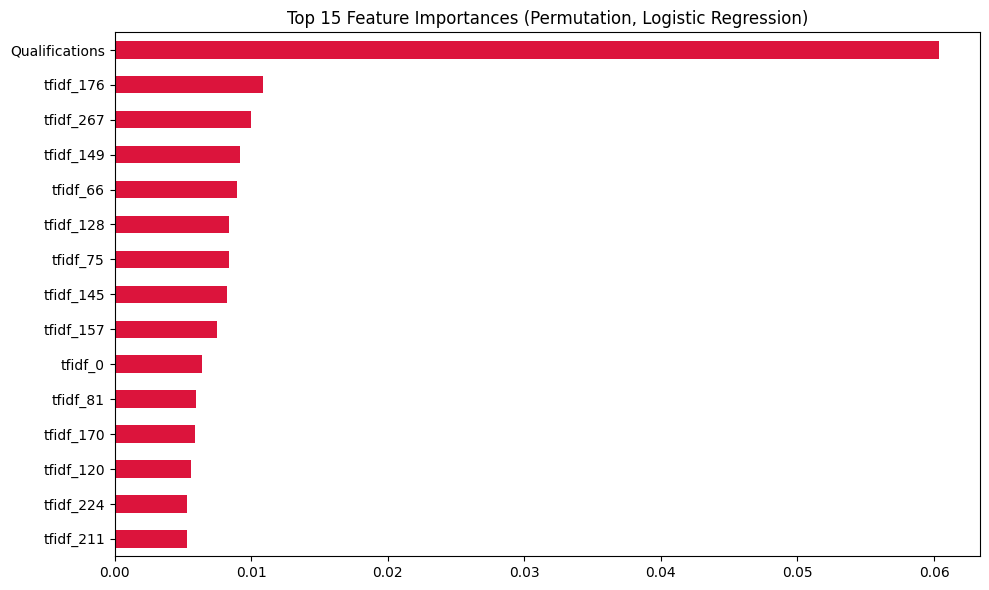

Qualifications    0.060350
tfidf_176         0.010872
tfidf_267         0.009984
tfidf_149         0.009153
tfidf_66          0.008986
tfidf_128         0.008406
tfidf_75          0.008355
tfidf_145         0.008203
tfidf_157         0.007529
tfidf_0           0.006373
tfidf_81          0.005996
tfidf_170         0.005893
tfidf_120         0.005602
tfidf_224         0.005338
tfidf_211         0.005268
dtype: float64

In [11]:
# Subsampling for speed
np.random.seed(42)
sample_idx = np.random.choice(len(y_test), size=min(1000, len(y_test)), replace=False)
Xte_sub = Xte[sample_idx]
y_test_sub = y_test[sample_idx]

# Computing Permutation Importance
result_lr = permutation_importance(
    model, Xte_sub, y_test_sub, n_repeats=3, random_state=42, scoring='f1_macro'
)

# feature names
if best_combo == 'structured':
    feature_names = train_df.drop(columns=['Job Title_encoded', 'salary_avg']).columns
elif best_combo == 'fused SBERT embeddings':
    feature_names = [f'sbert_emb_{i}' for i in range(Xte.shape[1])]
elif best_combo == 'tfidf embeddings':
    feature_names = [f'tfidf_{i}' for i in range(Xte.shape[1])]
else:  # str+emb
    struct_names = train_df.drop(columns=['Job Title_encoded', 'salary_avg']).columns
    tfidf_names = [f'tfidf_{i}' for i in range(X_dev_skills.shape[1])]
    feature_names = list(struct_names) + tfidf_names

importances_lr = pd.Series(result_lr.importances_mean, index=feature_names)
importances_lr = importances_lr.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_lr[:15].plot(kind='barh', color='crimson')
plt.title('Top 15 Feature Importances (Permutation, Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importances_lr.head(15)

## 2nd Model: K Neighbors Classifier

### Training and evaluating on the best feature set

In [12]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xtr, y_train)

# Evaluate on test set
y_test_pred_knn = model_knn.predict(Xte)
test_f1_knn = f1_score(y_test, y_test_pred_knn, average='macro')
print(f'KNN Test Macro F1: {test_f1_knn:.4f}')

# Save model
joblib.dump(model_knn, '/kaggle/working/knn_classifier_cuml.joblib')

KNN Test Macro F1: 0.6802


['/kaggle/working/knn_classifier_cuml.joblib']

### Visual 1: Confusion Matrix for KNN (Top 10 Job Titles)

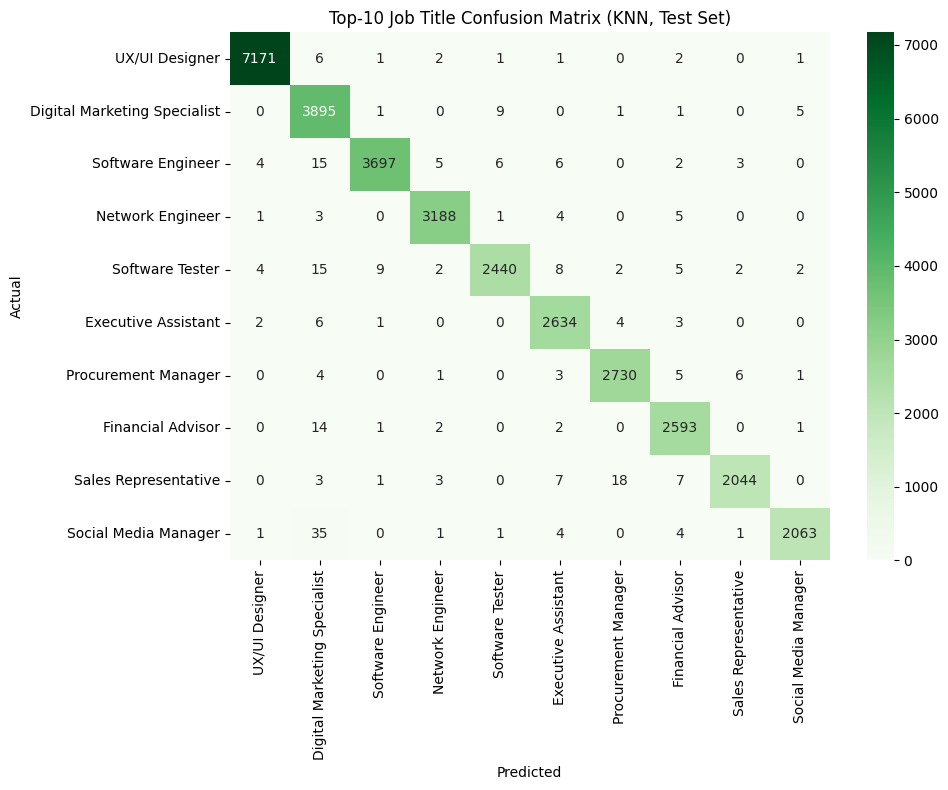

In [13]:
cm_knn = confusion_matrix(y_test, y_test_pred_knn, labels=top_10_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', 
            xticklabels=le.inverse_transform(top_10_classes), 
            yticklabels=le.inverse_transform(top_10_classes), cmap='Greens')
plt.title('Top-10 Job Title Confusion Matrix (KNN, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Visual 2: Permutation Importance for Logistic Regression


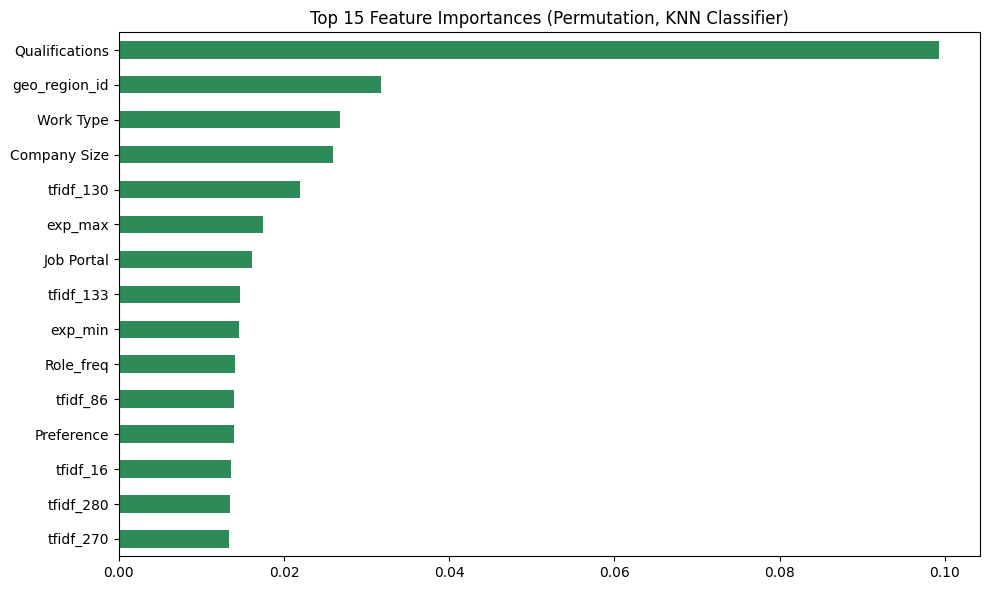

Qualifications    0.099296
geo_region_id     0.031744
Work Type         0.026768
Company Size      0.025889
tfidf_130         0.021988
exp_max           0.017482
Job Portal        0.016167
tfidf_133         0.014654
exp_min           0.014511
Role_freq         0.014031
tfidf_86          0.013903
Preference        0.013900
tfidf_16          0.013529
tfidf_280         0.013486
tfidf_270         0.013284
dtype: float64

In [14]:
# Compute permutation importance
result_knn = permutation_importance(
    model_knn, Xte_sub, y_test_sub, n_repeats=3, random_state=42, scoring='f1_macro'
)

importances_knn = pd.Series(result_knn.importances_mean, index=feature_names)
importances_knn = importances_knn.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_knn[:15].plot(kind='barh', color='seagreen')
plt.title('Top 15 Feature Importances (Permutation, KNN Classifier)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importances_knn.head(15)